In [13]:
from collections import defaultdict
from iteration_utilities import deepflatten
from pandas import read_csv
from sklearn.model_selection import train_test_split
from transformers import AutoModel, AutoTokenizer
import pickle
import torch

# Load labelled mass and weight instances
data = read_csv('../data/edited_data.csv')

# Filter records with 'en masse' due to negligible sample size (2 instances)
# and add a column with the full sentences
filtered = data[data.Sense != 'Q'].copy()
filtered['Sentences'] = filtered[['Context before', 'token', 'Context after']].agg(' '.join, axis=1)

# Split data for cross validation without data leakage
X_train, X_test, y_train, y_test = train_test_split(filtered, filtered.Sense, random_state=153, stratify=filtered.Sense)

# Save model and tokenizer locally
# AutoModel.from_pretrained('emanjavacas/MacBERTh').save_pretrained('../models/model')
# AutoTokenizer.from_pretrained('emanjavacas/MacBERTh').save_pretrained('../models/tokenizer')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load MacBERTh tokenizer and model (PyTorch). Set the model to evaluation mode.
macberth = AutoModel.from_pretrained('../models/model').to(device)
macberth.eval()
tokenizer = AutoTokenizer.from_pretrained('../models/tokenizer')

# Generate sentence embeddings
with torch.no_grad():
	ids_train = tokenizer(list(X_train.Sentences), return_tensors='pt', padding=True).to(device)
	output_train = macberth(**ids_train)
	ids_test = tokenizer(list(X_test.Sentences), return_tensors='pt', padding=True).to(device)
	output_test = macberth(**ids_test)

# Extract keyword embeddings
# Return the index of the keyword in the sentence
def get_keyword_idx (ids, tokenizer, keyword):
    subwords = tokenizer.convert_ids_to_tokens(ids)
    for idx, subword in enumerate(subwords):
        if keyword in subword:
            return idx

# Retreive the training keyword indexes
target = []
for idx, keyword in enumerate(list(X_train.token)):
    target.append(get_keyword_idx(ids_train.input_ids[idx], tokenizer, keyword))

# Retreive the training keyword embeddings
np_arr = output_train['last_hidden_state'].cpu().detach().numpy()
embeddings_train = []
for i in list(range(len(np_arr))):
    embeddings_train.append(np_arr[i][target[i]].tolist())

# Retreive the test keyword indexes
target = []
for idx, keyword in enumerate(list(X_test.token)):
    target.append(get_keyword_idx(ids_test.input_ids[idx], tokenizer, keyword))

# Retreive the test keyword embeddings
np_arr = output_test['last_hidden_state'].cpu().detach().numpy()
embeddings_test = []
for i in list(range(len(np_arr))):
    embeddings_test.append(np_arr[i][target[i]].tolist())

# Save the embeddings locally
with open('../out/embeddings.pkl', 'wb') as f:
    pickle.dump([embeddings_train, embeddings_test, y_train, y_test], f, protocol=-1)


/Users/davidjnatarajan/.pyenv/versions/3.9.10/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/davidjnatarajan/.pyenv/versions/3.9.10/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


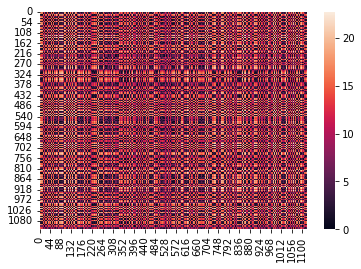

<AxesSubplot:>

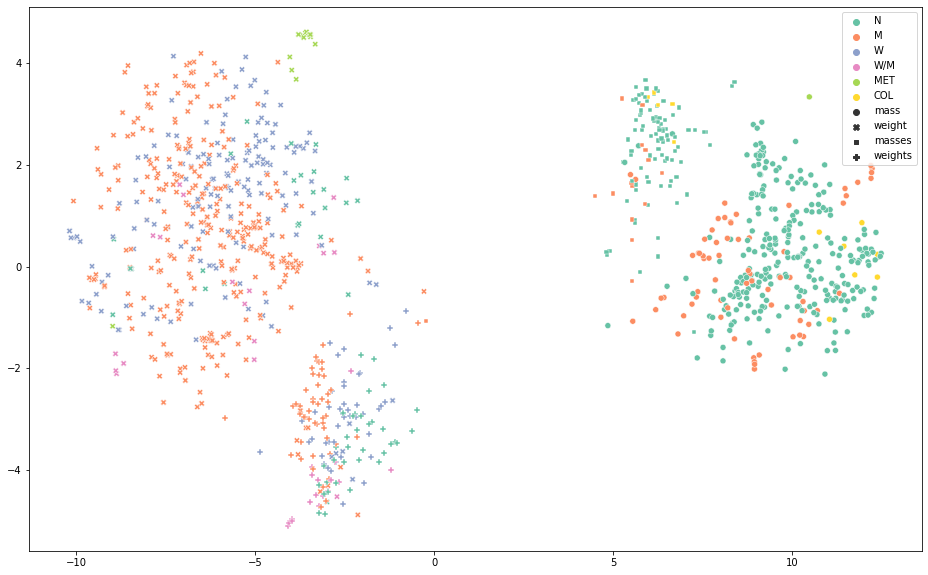

In [15]:
from matplotlib.pylab import figure, show
from seaborn import color_palette, heatmap, scatterplot
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import pairwise_distances
import sys

# pca_embeddings = PCA(n_components=50).fit_transform(embeddings_train)
tsne_embeddings = TSNE(perplexity=250, init='pca', random_state=153).fit_transform(embeddings_train)

distance = pairwise_distances(tsne_embeddings)
ax = heatmap(distance)
show()

figure(figsize=(16,10))
scatterplot(
    x=tsne_embeddings[:,0], y=tsne_embeddings[:,1],
    style=list(X_train.token),
    hue=list(X_train.Sense),
    palette=color_palette('Set2', len(set(list(X_train.Sense)))),
    legend="full",
)